Preamble: <br>
Author: Stephen Brownsey  <br>
Python version: 3.10.5 64-bit  <br>


The problem is to predict which cases will lapse and is broken down into three sections:
1. Data exploration: What are the most interesting features of the data set? What have you considered and why have you made the decisions you have done?
2. Modelling: What process did you follow when modelling retention? How have you designed your model and what did you account for
3. What are your conclusions and what else would’ve been useful to know?


In [65]:
#Library loading section
import pandas as pd
import numpy as np
import sklearn as skl
import sweetviz as sv
from tqdm import tqdm
from utils import get_missing_column_values
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import scipy.stats as st
import pickle
import matplotlib.pyplot as plt


In [19]:
data = pd.read_csv("data/home_insurance.csv").drop(columns = ["i", "Police"], errors = "ignore") #Dropping the two identifier columns i is the index and police is the police number

In [20]:
#First look
print("Number of Categorical Features: ", len([x for x in data.select_dtypes(include=['object'])]))
print("Number of Numeric Features:", len([x for x in data.select_dtypes(exclude=['object'])]))


Number of Categorical Features:  41
Number of Numeric Features: 23


In [21]:
#Sweetviz is a very good EDA library that shows you information about all the columns in the dataframe, takes a few minutes to run, so just open raw_data.html from repo to see this output
#my_report = sv.analyze(data)
#my_report.show_html("raw_data.html")



This sweetviz report quickly tells us a few things about the dataset:
1. There are 67115 cases where there is a missing policy status, since this is our dependent variable, rows which are missing here should be removed. This number of 67115 is also present in a lot of the other variables as such it backs up this thought. There are also 16 Unknown policies, since this is such a low number we can afford to remove them as well
2. There are some irrelevant columns which only have one option such as PAYMENT_FREQUENCY and CAMPAIGN_DESC which is all missing.
3. There are a number of variables that are majority missing, more analysis will be undertaken for these but it is expected that most will be dropped before modelling.
4. There are a number of date variables, which should be put through feature engineering before we add them to our model
5. Some columns are very heavily skewed so to consider whether these should be considered for the model or not
6. There are some numerical columns such as SUM_INSURED_CONTENTS/SUM_INSURED_BUILDING that are more ordinal than continuous so should be encoded as such
7. There are very strong associations between a lot of the columns, particularly around pre renewal and post renewal columns which highlights perhaps they should be combined. As well as sum assured and premium columns which are very strongly linked. The dataset should go through a rigourous feature selection process before being used for modelling to iron out as much of these correlations as possible
8. There are some outliers which will need looking at in more detail

In [22]:
# Looking into point 1:
# Quick look into the Null Policy status rows to see if it contains anything useful
data[pd.isnull(data.POL_STATUS)].describe()


,RISK_RATED_AREA_B,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,RISK_RATED_AREA_C,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,SPEC_SUM_INSURED,SPEC_ITEM_PREM,UNSPEC_HRP_PREM,BEDROOMS,...,MAX_DAYS_UNOCC,OWNERSHIP_TYPE,PAYING_GUESTS,PROP_TYPE,YEARBUILT,CAMPAIGN_DESC,PAYMENT_FREQUENCY,MTA_FAP,MTA_APRP,LAST_ANN_PREM_GROSS
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.000000,340.000000,1018.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.310382,96.815647,208.483094
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.129222,135.085932,101.016586
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910000,-78.590000,-1.910000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.257500,0.000000,141.207500
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.575000,0.000000,187.760000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278.680000,194.570000,260.105000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,650.380000,600.820000,721.960000


In [23]:
#Now update the data view to remove Unknown and Null policies
data = data[ (~pd.isnull(data.POL_STATUS)) & (data.POL_STATUS != "Unknown")]
#my_report = sv.analyze(data)
#my_report.show_html("full_dataset.html")


#### Point 2/Point 3: <br>
From point 2 it can be seen that PAYMENT_FREQUENCY AND CAMPAIGN_DESC should be dropped from the analysis as they are irrelevant.
Looking into Point 3, to start with will drop P1_PT_EMP_STATUS and CLERICAL as very high percentage missing and 


In [24]:
# Looking at point 2:
data.drop(["PAYMENT_FREQUENCY", "CAMPAIGN_DESC"],axis = 1, inplace=True)
missing_info = get_missing_column_values(df = data)
missing_info





,column,missing_count,missing_percentage
1,P1_PT_EMP_STATUS,187223,99.06
2,CLERICAL,186061,98.44
7,MTA_DATE,162578,86.02
5,MTA_FAP,133630,70.70
6,MTA_APRP,133630,70.70
0,QUOTE_DATE,109868,58.13
3,RISK_RATED_AREA_B,48140,25.47
4,RISK_RATED_AREA_C,8731,4.62


In [25]:
def index_insight(column, data = data):
    nulled = data[(pd.isnull(data[column]))]["POL_STATUS"]
    contained = data[ (~pd.isnull(data[column]))]["POL_STATUS"] 
    total_null = len(nulled)
    total_contained = len(contained)
    nulled = pd.DataFrame(nulled.value_counts() ).rename(columns= {"POL_STATUS": "nulled"})
    contained = pd.DataFrame(contained.value_counts()).rename(columns= {"POL_STATUS": "contained"})
    df = pd.concat([nulled, contained], axis = 1).reset_index().rename(columns = {"index":"POL_STATUS"})
    df["index"] = round( (df.contained/total_contained)/(df.nulled/total_null), 3)
    df["column"] = column
    return df[["column", "POL_STATUS", "contained", "nulled", "index"]]

indexes = index_insight('P1_PT_EMP_STATUS')
iterate_cols = missing_info.column.unique().tolist()
iterate_cols.remove('P1_PT_EMP_STATUS')

for column in iterate_cols:
    temp = index_insight(column)
    indexes = pd.concat([indexes, temp])
indexes


#Switching P1_PT_EMP_STATUS to be a second job indicator
data["second_job"] = np.select([
    (pd.isnull(data["P1_PT_EMP_STATUS"])),
    (~pd.isnull(data["P1_PT_EMP_STATUS"]))
], ["N", "Y"] )
data.drop(["P1_PT_EMP_STATUS", "CLERICAL"], axis = 1, inplace=True)



In [26]:
# Looking at NAs in MTA_FAP and MTA_APRP: These columns are the bonusup to date of adjustment and the adjustment of the premium
# going to replace all the NaNs with 0 as if there was no adjustment then no midterm change occured
data[["MTA_FAP", "MTA_APRP"]] = data[["MTA_FAP", "MTA_APRP"]].fillna(0)

In [27]:
# Looking at the RISK_Rated columns, we note that a higher number can be associated with a higher risk
# 0 is the most common result for both of them and it would be a reasonable assumption that if it was null then there is a low risk so again just going to fillnas with 0
# Potentially could build another model to predict the number , but feels overkill
data[["RISK_RATED_AREA_B", "RISK_RATED_AREA_C"]] = data[["RISK_RATED_AREA_B", "RISK_RATED_AREA_C"]].fillna(0)

#### Point 4: <br>
There are 4 columns which are dates - these are encoded as object columns in the df, so convert them to datetime and perform feature engineering on them.
Columns are: QUOTE_DATE, COVER_START, P1_DOB, MTA_DATE <br>
Feature engineering of date columns:<br>
MTA_DATE will be dropped, this is due both the large % of missing data and the three other MTA related columns <br>
P1_DOB will be changed to age at policy start <br>
For COVER_START day and month will be extracted as could provide some insight if there are weekly/day variations <br>
QUOTE_DATE has lots of nulls, so we'll change it to a categorical column of "Unknown", "Same as Cover Start", "within 2 week of cover start" and "great than 2 weeks of cover start". There could be an underlying reason for the Nulls such as that policy came in via an agent so was always on the same day as start date, but without deeper knowledge of the dataset impossible for know so just encoding to "Unknown" for now. There were some cases that QUOTE_DATE is after COVER_START which looks wrong.

In [49]:
data.drop("MTA_DATE", axis = 1, inplace=True)
data[["QUOTE_DATE", "COVER_START", "P1_DOB"]] = data[["QUOTE_DATE", "COVER_START", "P1_DOB"]].apply(lambda _: pd.to_datetime(_, infer_datetime_format=True ,errors='coerce'))

In [29]:
data
data["quote_variation"] = (data.COVER_START - data.QUOTE_DATE)/np.timedelta64(1, "D")
print("Number of Cases with Quote Date After Start Date: " + str(len(data["quote_variation"][data.quote_variation < 0])))

def quote_date_updator(row):
    if(pd.isnull(row)):
        return "unknown"
    elif(abs(row) <= 14):
        return "less_than_14_days"
    elif(abs(row) > 14):
        return "greater_than_14_days"


data["quote_variation"] = data.quote_variation.apply(quote_date_updator)#.value_counts()
data.drop("QUOTE_DATE", axis = 1, inplace=True)



Number of Cases with Quote Date After Start Date: 475


In [30]:
#Calculating user age
data['Age'] = (data['COVER_START'] - data['P1_DOB']).astype('timedelta64[Y]').astype('int')
data.drop("P1_DOB", axis = 1, inplace=True)
#Switching Quote and Cover Start days into Day of week and month of year
def date_feature_engineerer(data = data, column = "COVER_START", prefix = "cover_start"):
    column1 = prefix + "_day_of_week"
    column2 = prefix + "_month"
    data[column1] = data[column].dt.day_name()
    data[column2] = data[column].dt.month_name()
    data.drop(column, axis = 1, inplace=True)

date_feature_engineerer()


###### Point 5:

Going to use an XGB algorithm to start with and this handles skewed data well so no need to overly worry about it.


###### Point 6:
Encoding the ordinal float columns instead of continuous

In [31]:
def update_sum_insured_contents(row):
    if row == 0:
        return 0
    elif row == 50000:
        return 1
    elif row == 55000:
        return 2
    elif row == 60000:
        return 3
    elif row == 65000:
        return 4
    elif row == 70000:
        return 5
    elif row == 75000:
        return 6
    elif row == 80000:
        return 7
    elif row == 85000:
        return 8
    elif row == 90000:
        return 9
    else:
        return 10

data["SUM_INSURED_CONTENTS"] = data["SUM_INSURED_CONTENTS"].apply(update_sum_insured_contents)

In [32]:
data["SUM_INSURED_BUILDINGS"] = data["SUM_INSURED_BUILDINGS"].replace({0.0:"N", 1000000.0:"Y"})


###### Points 7
Looking at the strong associations in the data, going to combine the pre and post columns into one column <br>
Going to remove the premium columns, these are driving by a combination of the other columns, particularly sum assured

In [33]:
def pre_post_combiner(data = data, column = "LEGAL_ADDON"):
    """Combine pre and post columns

    Args:
        data (pd.DataFrame, optional): Dataframe to apply combining to. Defaults to data.
        column (str, optional): Column to apply combining to. Defaults to "LEGAL_ADDON".
    """
    pre = column + "_ADDON_PRE_REN"
    post = column + "_ADDON_POST_REN"
    data[column] = data[pre] + data[post]
    data.drop([pre, post], axis = 1, inplace=True)

cols = ["LEGAL", "HOME_EM", "GARDEN", "KEYCARE", "HP1", "HP2", "HP3"]
for col in cols:
    pre_post_combiner(column = col)

In [34]:
#Dropping the Premium columns - signified by _PREM_ so it keeps last years premium
data.drop(list(data.filter(regex = '_PREM_')), axis = 1, inplace = True)

In [35]:
cols = [x for x in data.select_dtypes(include=['object'])]
cols.remove("POL_STATUS")
modelling_df = pd.get_dummies(data, columns= cols)
modelling_df.head()

,RISK_RATED_AREA_B,NCD_GRANTED_YEARS_B,RISK_RATED_AREA_C,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,SPEC_SUM_INSURED,SPEC_ITEM_PREM,UNSPEC_HRP_PREM,BEDROOMS,ROOF_CONSTRUCTION,...,HP1_YN,HP1_YY,HP2_NN,HP2_NY,HP2_YN,HP2_YY,HP3_NN,HP3_NY,HP3_YN,HP3_YY
0,19.0,7.0,6.0,1,7.0,7500.0,44.42,12.45,3.0,11.0,...,0,0,1,0,0,0,1,0,0,0
1,25.0,6.0,9.0,1,7.0,0.0,0.00,24.60,3.0,11.0,...,0,0,1,0,0,0,1,0,0,0
2,0.0,0.0,12.0,1,7.0,0.0,0.00,0.00,2.0,11.0,...,0,0,1,0,0,0,1,0,0,0
3,0.0,0.0,14.0,1,7.0,0.0,0.00,0.00,2.0,11.0,...,0,0,1,0,0,0,1,0,0,0
4,5.0,7.0,10.0,1,7.0,0.0,0.00,19.82,3.0,11.0,...,0,0,1,0,0,0,1,0,0,0


In [36]:
#my_report = sv.analyze(modelling_df)
#my_report.show_html("model_dataset.html")

In [47]:
#Mapping into 0,1, 2 for XGB algorithm
def update_pol_status(row):
    if row == "Live":
        return 0
    elif row == "Lapsed":
        return 1
    elif row == "Cancelled":
        return 2
        
modelling_df["POL_STATUS"] = modelling_df["POL_STATUS"].apply(update_pol_status)

In [46]:
X, X_validation, y, y_validation  = train_test_split(
    modelling_df.drop("POL_STATUS", axis = 1), modelling_df.POL_STATUS, test_size= 0.25, random_state= 666)
best_params = []
best_score = []
#le = LabelEncoder()
#y = le.fit_transform(y)
y

889         Live
3003        Live
52773       Live
139631    Lapsed
242096      Live
           ...  
55087       Live
3121        Live
169254      Live
54360       Live
101781      Live
Name: POL_STATUS, Length: 141753, dtype: object

In [50]:
modelling_df.drop("MTA_DATE", axis = 1, inplace=True)

Entry XGBOOST

In [51]:
#Split data
def split_data(data = modelling_df, column = "POL_STATUS",test_size = 0.25):
    return train_test_split(data.drop(column, axis = 1), data[column], test_size= 0.25, random_state= 666)
    
def get_xgb_best_params(data = modelling_df, objective = "multi:softmax", cv = 3,n_iter = 100):
    X, X_validation, y, y_validation = split_data()

    best_params = []
    best_score = []

    #Kfold Cross validation part of the code
    kf = StratifiedKFold(n_splits = 3)# Would increase this if more time but didnt want it to run too long
    for train_index, test_index in kf.split(X, y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        

        estimator = xgb.XGBClassifier(nthreads=-1, use_label_encoder= False, objective= objective)
        params = {  
            "n_estimators": st.randint(3, 40),
            "max_depth": st.randint(3, 40),
            "learning_rate": st.uniform(0.05, 0.4),
            "colsample_bytree": st.beta(10, 1),
            "subsample": st.beta(10, 1),
            "gamma": st.uniform(0, 10),
            'objective': [objective],
            'scale_pos_weight': st.randint(0, 2),
            "min_child_weight": st.expon(0, 50),
        }

        clf = RandomizedSearchCV(estimator, params, cv = cv,
                                n_jobs = -1, n_iter = n_iter) 
                                    
        clf.fit(X_train, y_train.values)  
        best_params.append(clf.best_params_)
        best_score.append(clf.best_score_)   

    #Getting best parameters from CV
    best_params = best_params[best_score.index(max(best_score))]
    return best_params


[17:50:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthreads", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthreads", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:20:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthreads"

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.641943823817405, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=5.376856019584292, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2650983955111818, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=33, max_leaves=0,
              min_child_weight=19.491556673037902, missing=nan,
              monotone_constraints='()', n_estimators=39, n_jobs=0, nthreads=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, ...)

In [ ]:
#Split data
X, X_validation, y, y_validation  = train_test_split(
    modelling_df.drop("POL_STATUS", axis = 1), modelling_df.POL_STATUS, test_size= 0.25, random_state= 666)
best_params = []
best_score = []

#Kfold Cross validation part of the code
kf = StratifiedKFold(n_splits = 3)# Would increase this if more time but didnt want it to run too long
for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    estimator = xgb.XGBClassifier(nthreads=-1, use_label_encoder= False, objective="multi:softmax")
    params = {  
        "n_estimators": st.randint(3, 40),
        "max_depth": st.randint(3, 40),
        "learning_rate": st.uniform(0.05, 0.4),
        "colsample_bytree": st.beta(10, 1),
        "subsample": st.beta(10, 1),
        "gamma": st.uniform(0, 10),
        'objective': ["multi:softmax"],
        'scale_pos_weight': st.randint(0, 2),
        "min_child_weight": st.expon(0, 50),
    }

    clf = RandomizedSearchCV(estimator, params, cv = 3,
                            n_jobs = -1, n_iter = 100) 
                                
    clf.fit(X_train, y_train.values)  
    best_params.append(clf.best_params_)
    best_score.append(clf.best_score_)   

#Getting best parameters from CV
best_params = best_params[best_score.index(max(best_score))]


In [56]:

f = open("best_params.pkl","wb")
pickle.dump(best_params,f)
f.close()


In [57]:
infile = open("best_params.pkl",'rb')
new_dict = pickle.load(infile)
infile.close()

In [53]:
#Fitting final model
clf = xgb.XGBClassifier(nthreads=-1, **best_params, use_label_encoder= False) 
clf.fit(X, y)                             


[18:25:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthreads", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.641943823817405, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=5.376856019584292, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2650983955111818, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=33, max_leaves=0,
              min_child_weight=19.491556673037902, missing=nan,
              monotone_constraints='()', n_estimators=39, n_jobs=0, nthreads=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, ...)

In [54]:
clf_predict = clf.predict(X_validation)
print("F1 Score is: " + str(round(f1_score(y_validation, clf_predict, average='weighted'), 3) ) )

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, clf.feature_importances_):
    feats[feature] = importance

pd.Series(feats).sort_values(ascending = False)

F1 Score is: 0.719


LEGAL_YN                    0.181915
quote_variation_unknown     0.063698
PAYMENT_METHOD_NonDD        0.062174
P1_MAR_STATUS_P             0.057411
PAYMENT_METHOD_PureDD       0.055248
                              ...   
cover_start_month_August    0.000000
OCC_STATUS_OT               0.000000
OCC_STATUS_WD               0.000000
OCC_STATUS_WE               0.000000
HP3_YY                      0.000000
Length: 135, dtype: float32

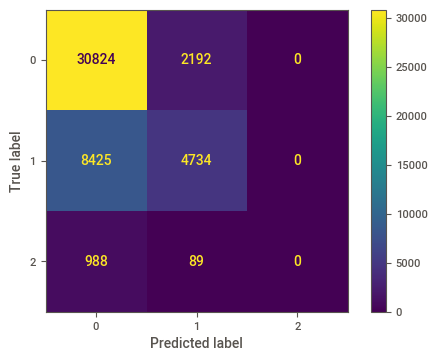

In [64]:
ConfusionMatrixDisplay.from_predictions(y_validation, clf_predict)
plt.show()

In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

multiclass_roc_auc_score(y_validation, clf_predict)

0.5942075807002872